In [2]:
# Upload your files
from google.colab import files
import io

# Upload corpus.txt and test_words.txt
uploaded = files.upload()  # Upload corpus.txt
uploaded = files.upload()  # Upload test_words.txt

# Install required packages
!pip install torch tqdm matplotlib

Saving test.txt to test.txt


Saving corpus.txt to corpus.txt


In [3]:
"""
Hangman Solver - Part 1: Hidden Markov Model Training
This notebook trains HMMs for different word lengths to predict letter probabilities
"""

import numpy as np
import pickle
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================================
# STEP 1: Load and Preprocess Corpus
# ============================================================================

def load_corpus(filepath='corpus.txt'):
    """Load and preprocess the word corpus"""
    with open(filepath, 'r') as f:
        words = [line.strip().upper() for line in f if line.strip()]

    print(f"Loaded {len(words)} words")
    print(f"Word length range: {min(len(w) for w in words)} to {max(len(w) for w in words)}")

    # Group words by length
    words_by_length = defaultdict(list)
    for word in words:
        words_by_length[len(word)].append(word)

    return words, words_by_length

# ============================================================================
# STEP 2: Build HMM for Each Word Length
# ============================================================================

class HangmanHMM:
    """
    HMM for Hangman where:
    - Hidden States: Position in word (0, 1, 2, ..., length-1)
    - Emissions: Letters (A-Z)
    """

    def __init__(self, word_length):
        self.word_length = word_length
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.letter_to_idx = {c: i for i, c in enumerate(self.alphabet)}

        # Emission probabilities: P(letter | position)
        # Shape: (word_length, 26)
        self.emission_probs = np.zeros((word_length, 26))

        # Overall letter frequencies (for smoothing)
        self.letter_freqs = np.zeros(26)

    def train(self, words):
        """Train HMM on a list of words of the same length"""

        # Count emissions: how often each letter appears at each position
        emission_counts = np.zeros((self.word_length, 26))
        total_counts = np.zeros(26)

        for word in words:
            for pos, letter in enumerate(word):
                if letter in self.letter_to_idx:
                    idx = self.letter_to_idx[letter]
                    emission_counts[pos][idx] += 1
                    total_counts[idx] += 1

        # Calculate probabilities with Laplace smoothing
        alpha = 1.0  # Smoothing parameter

        for pos in range(self.word_length):
            # Add smoothing
            emission_counts[pos] += alpha
            total = emission_counts[pos].sum()
            self.emission_probs[pos] = emission_counts[pos] / total

        # Overall letter frequencies (normalized)
        self.letter_freqs = (total_counts + alpha) / (total_counts.sum() + 26 * alpha)

    def predict_letter_probs(self, masked_word, guessed_letters):
        """
        Given current game state, predict probability of each letter

        Args:
            masked_word: string like "_A_E_"
            guessed_letters: set of already guessed letters

        Returns:
            dict: {letter: probability} for unguessed letters
        """

        probs = np.zeros(26)
        unknown_positions = []

        # For each unknown position, get emission probabilities
        for pos, char in enumerate(masked_word):
            if char == '_':
                unknown_positions.append(pos)
                probs += self.emission_probs[pos]

        # Average across unknown positions
        if unknown_positions:
            probs /= len(unknown_positions)
        else:
            # Fallback to letter frequencies
            probs = self.letter_freqs.copy()

        # Zero out already guessed letters
        for letter in guessed_letters:
            if letter in self.letter_to_idx:
                probs[self.letter_to_idx[letter]] = 0

        # Normalize
        if probs.sum() > 0:
            probs /= probs.sum()

        # Convert to dict
        result = {}
        for i, letter in enumerate(self.alphabet):
            if letter not in guessed_letters:
                result[letter] = probs[i]

        return result

# ============================================================================
# STEP 3: Train HMMs for All Word Lengths
# ============================================================================

def train_all_hmms(words_by_length):
    """Train HMM for each word length"""

    hmms = {}

    for length in tqdm(sorted(words_by_length.keys()), desc="Training HMMs"):
        words = words_by_length[length]

        hmm = HangmanHMM(length)
        hmm.train(words)
        hmms[length] = hmm

        print(f"Length {length}: Trained on {len(words)} words")

    return hmms

# ============================================================================
# STEP 4: Enhanced Word Filtering Strategy
# ============================================================================

class WordMatcher:
    """Smart word matching and filtering"""

    def __init__(self, words):
        self.all_words = set(words)
        self.words_by_length = defaultdict(set)

        for word in words:
            self.words_by_length[len(word)].add(word)

    def get_matching_words(self, masked_word, guessed_letters):
        """Get all words matching the current pattern"""

        length = len(masked_word)
        candidates = self.words_by_length[length]

        matching = []
        for word in candidates:
            if self.matches_pattern(word, masked_word, guessed_letters):
                matching.append(word)

        return matching

    def matches_pattern(self, word, pattern, guessed_letters):
        """Check if word matches the masked pattern"""

        if len(word) != len(pattern):
            return False

        for w_char, p_char in zip(word, pattern):
            if p_char != '_' and w_char != p_char:
                return False
            if p_char == '_' and w_char in guessed_letters:
                return False

        # Check that guessed letters that appear are in correct positions
        for letter in guessed_letters:
            letter_in_word = letter in word
            letter_in_pattern = letter in pattern
            if letter_in_word != letter_in_pattern:
                return False

        return True

    def get_letter_frequencies(self, words, guessed_letters):
        """Get letter frequency distribution from candidate words"""

        counter = Counter()
        for word in words:
            for letter in word:
                if letter not in guessed_letters:
                    counter[letter] += 1

        total = sum(counter.values())
        if total == 0:
            return {}

        return {letter: count / total for letter, count in counter.items()}

# ============================================================================
# STEP 5: Save Models
# ============================================================================

def save_models(hmms, words, filepath='hangman_models.pkl'):
    """Save trained HMMs and word list"""

    data = {
        'hmms': hmms,
        'words': words
    }

    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

    print(f"Models saved to {filepath}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("=" * 60)
    print("HANGMAN HMM TRAINING")
    print("=" * 60)

    # Load corpus
    words, words_by_length = load_corpus('corpus.txt')

    # Train HMMs
    print("\nTraining HMMs for each word length...")
    hmms = train_all_hmms(words_by_length)

    # Create word matcher
    word_matcher = WordMatcher(words)

    # Test HMM on sample word
    print("\n" + "=" * 60)
    print("TESTING HMM")
    print("=" * 60)

    test_word = "APPLE"
    masked = "A___E"
    guessed = set(['A', 'E'])

    hmm = hmms[len(test_word)]
    probs = hmm.predict_letter_probs(masked, guessed)

    print(f"\nTest word: {test_word}")
    print(f"Masked: {masked}")
    print(f"Guessed: {guessed}")
    print(f"\nTop 5 predicted letters:")
    for letter, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {letter}: {prob:.4f}")

    # Save everything
    print("\n" + "=" * 60)
    save_models(hmms, words)

    # Save word matcher separately
    with open('word_matcher.pkl', 'wb') as f:
        pickle.dump(word_matcher, f)

    print("\n✅ HMM Training Complete!")

HANGMAN HMM TRAINING
Loaded 50000 words
Word length range: 1 to 24

Training HMMs for each word length...


Training HMMs:  38%|███▊      | 9/24 [00:00<00:00, 70.45it/s]

Length 1: Trained on 46 words
Length 2: Trained on 84 words
Length 3: Trained on 388 words
Length 4: Trained on 1169 words
Length 5: Trained on 2340 words
Length 6: Trained on 3755 words
Length 7: Trained on 5111 words
Length 8: Trained on 6348 words
Length 9: Trained on 6808 words
Length 10: Trained on 6465 words
Length 11: Trained on 5452 words


Training HMMs: 100%|██████████| 24/24 [00:00<00:00, 67.41it/s]

Length 12: Trained on 4292 words
Length 13: Trained on 3094 words
Length 14: Trained on 2019 words
Length 15: Trained on 1226 words
Length 16: Trained on 698 words
Length 17: Trained on 375 words
Length 18: Trained on 174 words
Length 19: Trained on 88 words
Length 20: Trained on 40 words
Length 21: Trained on 16 words
Length 22: Trained on 8 words
Length 23: Trained on 3 words
Length 24: Trained on 1 words

TESTING HMM

Test word: APPLE
Masked: A___E
Guessed: {'E', 'A'}

Top 5 predicted letters:
  I: 0.1099
  O: 0.1090
  R: 0.1014
  U: 0.0898
  L: 0.0803

Models saved to hangman_models.pkl

✅ HMM Training Complete!


HANGMAN RL TRAINING

Loading HMMs...
Creating environment...

State size: 619
Action size: 26
Device: cuda

Starting training...


Training:   0%|          | 5/5000 [00:00<04:02, 20.56it/s]/tmp/ipython-input-1795879469.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([t[0] for t in batch]).to(self.device)
Training:   2%|▏         | 101/5000 [00:20<20:11,  4.04it/s]


Episode 100/5000
  Avg Score: -122.05
  Win Rate: 2.97%
  Epsilon: 0.603
  Recent Wins: 3/100


Training:   4%|▍         | 202/5000 [00:41<14:31,  5.51it/s]


Episode 200/5000
  Avg Score: -128.30
  Win Rate: 1.49%
  Epsilon: 0.365
  Recent Wins: 0/100


Training:   6%|▌         | 301/5000 [01:03<14:11,  5.52it/s]


Episode 300/5000
  Avg Score: -122.10
  Win Rate: 1.33%
  Epsilon: 0.221
  Recent Wins: 1/100


Training:   8%|▊         | 401/5000 [01:25<14:10,  5.41it/s]


Episode 400/5000
  Avg Score: -102.95
  Win Rate: 2.24%
  Epsilon: 0.134
  Recent Wins: 6/100


Training:  10%|█         | 501/5000 [01:46<25:28,  2.94it/s]


Episode 500/5000
  Avg Score: -109.25
  Win Rate: 2.99%
  Epsilon: 0.081
  Recent Wins: 6/100


Training:  12%|█▏        | 602/5000 [02:07<12:55,  5.67it/s]


Episode 600/5000
  Avg Score: -122.70
  Win Rate: 2.66%
  Epsilon: 0.049
  Recent Wins: 1/100


Training:  14%|█▍        | 701/5000 [02:30<17:24,  4.12it/s]


Episode 700/5000
  Avg Score: -99.00
  Win Rate: 3.14%
  Epsilon: 0.030
  Recent Wins: 7/100


Training:  16%|█▌        | 801/5000 [02:53<15:21,  4.56it/s]


Episode 800/5000
  Avg Score: -102.95
  Win Rate: 3.12%
  Epsilon: 0.018
  Recent Wins: 3/100


Training:  18%|█▊        | 902/5000 [03:17<12:52,  5.31it/s]


Episode 900/5000
  Avg Score: -99.50
  Win Rate: 3.44%
  Epsilon: 0.011
  Recent Wins: 6/100


Training:  20%|██        | 1002/5000 [03:40<13:41,  4.87it/s]


Episode 1000/5000
  Avg Score: -103.85
  Win Rate: 3.70%
  Epsilon: 0.010
  Recent Wins: 6/100


Training:  22%|██▏       | 1101/5000 [04:02<15:04,  4.31it/s]


Episode 1100/5000
  Avg Score: -113.75
  Win Rate: 3.63%
  Epsilon: 0.010
  Recent Wins: 4/100


Training:  24%|██▍       | 1202/5000 [04:26<15:44,  4.02it/s]


Episode 1200/5000
  Avg Score: -98.35
  Win Rate: 3.83%
  Epsilon: 0.010
  Recent Wins: 6/100


Training:  26%|██▌       | 1301/5000 [04:47<14:27,  4.26it/s]


Episode 1300/5000
  Avg Score: -93.95
  Win Rate: 4.23%
  Epsilon: 0.010
  Recent Wins: 9/100


Training:  28%|██▊       | 1402/5000 [05:10<11:38,  5.15it/s]


Episode 1400/5000
  Avg Score: -98.80
  Win Rate: 4.35%
  Epsilon: 0.010
  Recent Wins: 6/100


Training:  30%|███       | 1502/5000 [05:33<11:26,  5.10it/s]


Episode 1500/5000
  Avg Score: -85.00
  Win Rate: 4.73%
  Epsilon: 0.010
  Recent Wins: 10/100


Training:  32%|███▏      | 1601/5000 [05:56<12:40,  4.47it/s]


Episode 1600/5000
  Avg Score: -98.60
  Win Rate: 4.75%
  Epsilon: 0.010
  Recent Wins: 5/100


Training:  34%|███▍      | 1701/5000 [06:18<10:49,  5.08it/s]


Episode 1700/5000
  Avg Score: -105.65
  Win Rate: 4.76%
  Epsilon: 0.010
  Recent Wins: 5/100


Training:  36%|███▌      | 1802/5000 [06:42<11:06,  4.79it/s]


Episode 1800/5000
  Avg Score: -113.10
  Win Rate: 4.55%
  Epsilon: 0.010
  Recent Wins: 1/100


Training:  38%|███▊      | 1902/5000 [07:05<09:17,  5.56it/s]


Episode 1900/5000
  Avg Score: -103.60
  Win Rate: 4.42%
  Epsilon: 0.010
  Recent Wins: 2/100


Training:  40%|████      | 2001/5000 [07:29<12:22,  4.04it/s]


Episode 2000/5000
  Avg Score: -102.25
  Win Rate: 4.45%
  Epsilon: 0.010
  Recent Wins: 5/100


Training:  42%|████▏     | 2102/5000 [07:51<10:48,  4.47it/s]


Episode 2100/5000
  Avg Score: -103.05
  Win Rate: 4.52%
  Epsilon: 0.010
  Recent Wins: 6/100


Training:  44%|████▍     | 2202/5000 [08:15<13:57,  3.34it/s]


Episode 2200/5000
  Avg Score: -89.00
  Win Rate: 4.63%
  Epsilon: 0.010
  Recent Wins: 8/100


Training:  46%|████▌     | 2301/5000 [08:39<16:39,  2.70it/s]


Episode 2300/5000
  Avg Score: -100.65
  Win Rate: 4.52%
  Epsilon: 0.010
  Recent Wins: 2/100


Training:  48%|████▊     | 2401/5000 [09:01<10:41,  4.05it/s]


Episode 2400/5000
  Avg Score: -89.45
  Win Rate: 4.71%
  Epsilon: 0.010
  Recent Wins: 9/100


Training:  50%|█████     | 2501/5000 [09:25<08:57,  4.65it/s]


Episode 2500/5000
  Avg Score: -87.30
  Win Rate: 5.00%
  Epsilon: 0.010
  Recent Wins: 12/100


Training:  52%|█████▏    | 2601/5000 [09:48<09:16,  4.31it/s]


Episode 2600/5000
  Avg Score: -81.60
  Win Rate: 5.23%
  Epsilon: 0.010
  Recent Wins: 12/100


Training:  54%|█████▍    | 2702/5000 [10:11<07:02,  5.43it/s]


Episode 2700/5000
  Avg Score: -83.60
  Win Rate: 5.48%
  Epsilon: 0.010
  Recent Wins: 12/100


Training:  56%|█████▌    | 2801/5000 [10:34<07:16,  5.04it/s]


Episode 2800/5000
  Avg Score: -92.90
  Win Rate: 5.61%
  Epsilon: 0.010
  Recent Wins: 9/100


Training:  58%|█████▊    | 2901/5000 [10:57<07:29,  4.67it/s]


Episode 2900/5000
  Avg Score: -84.20
  Win Rate: 5.72%
  Epsilon: 0.010
  Recent Wins: 9/100


Training:  60%|██████    | 3001/5000 [11:20<07:45,  4.30it/s]


Episode 3000/5000
  Avg Score: -89.70
  Win Rate: 5.83%
  Epsilon: 0.010
  Recent Wins: 9/100


Training:  62%|██████▏   | 3102/5000 [11:44<06:14,  5.06it/s]


Episode 3100/5000
  Avg Score: -83.60
  Win Rate: 5.93%
  Epsilon: 0.010
  Recent Wins: 9/100


Training:  64%|██████▍   | 3201/5000 [12:07<07:02,  4.25it/s]


Episode 3200/5000
  Avg Score: -82.65
  Win Rate: 6.09%
  Epsilon: 0.010
  Recent Wins: 11/100


Training:  66%|██████▌   | 3301/5000 [12:30<06:42,  4.22it/s]


Episode 3300/5000
  Avg Score: -79.30
  Win Rate: 6.27%
  Epsilon: 0.010
  Recent Wins: 12/100


Training:  68%|██████▊   | 3401/5000 [12:54<07:01,  3.80it/s]


Episode 3400/5000
  Avg Score: -87.50
  Win Rate: 6.29%
  Epsilon: 0.010
  Recent Wins: 7/100


Training:  70%|███████   | 3501/5000 [13:17<09:23,  2.66it/s]


Episode 3500/5000
  Avg Score: -80.50
  Win Rate: 6.40%
  Epsilon: 0.010
  Recent Wins: 10/100


Training:  72%|███████▏  | 3601/5000 [13:39<04:45,  4.90it/s]


Episode 3600/5000
  Avg Score: -82.95
  Win Rate: 6.50%
  Epsilon: 0.010
  Recent Wins: 10/100


Training:  74%|███████▍  | 3701/5000 [14:02<03:24,  6.36it/s]


Episode 3700/5000
  Avg Score: -88.10
  Win Rate: 6.59%
  Epsilon: 0.010
  Recent Wins: 10/100


Training:  76%|███████▌  | 3801/5000 [14:25<04:06,  4.86it/s]


Episode 3800/5000
  Avg Score: -88.70
  Win Rate: 6.68%
  Epsilon: 0.010
  Recent Wins: 10/100


Training:  78%|███████▊  | 3901/5000 [14:48<04:17,  4.26it/s]


Episode 3900/5000
  Avg Score: -82.75
  Win Rate: 6.77%
  Epsilon: 0.010
  Recent Wins: 10/100


Training:  80%|████████  | 4002/5000 [15:12<03:21,  4.94it/s]


Episode 4000/5000
  Avg Score: -96.95
  Win Rate: 6.70%
  Epsilon: 0.010
  Recent Wins: 4/100


Training:  82%|████████▏ | 4102/5000 [15:34<03:16,  4.57it/s]


Episode 4100/5000
  Avg Score: -95.75
  Win Rate: 6.73%
  Epsilon: 0.010
  Recent Wins: 8/100


Training:  84%|████████▍ | 4201/5000 [15:57<02:54,  4.58it/s]


Episode 4200/5000
  Avg Score: -91.20
  Win Rate: 6.76%
  Epsilon: 0.010
  Recent Wins: 8/100


Training:  86%|████████▌ | 4302/5000 [16:20<02:58,  3.90it/s]


Episode 4300/5000
  Avg Score: -84.90
  Win Rate: 6.79%
  Epsilon: 0.010
  Recent Wins: 8/100


Training:  88%|████████▊ | 4401/5000 [16:42<02:53,  3.45it/s]


Episode 4400/5000
  Avg Score: -89.20
  Win Rate: 6.88%
  Epsilon: 0.010
  Recent Wins: 11/100


Training:  90%|█████████ | 4501/5000 [17:06<02:05,  3.96it/s]


Episode 4500/5000
  Avg Score: -78.05
  Win Rate: 6.98%
  Epsilon: 0.010
  Recent Wins: 11/100


Training:  92%|█████████▏| 4601/5000 [17:29<01:21,  4.92it/s]


Episode 4600/5000
  Avg Score: -78.85
  Win Rate: 7.09%
  Epsilon: 0.010
  Recent Wins: 12/100


Training:  94%|█████████▍| 4701/5000 [17:53<00:54,  5.50it/s]


Episode 4700/5000
  Avg Score: -96.15
  Win Rate: 7.08%
  Epsilon: 0.010
  Recent Wins: 7/100


Training:  96%|█████████▌| 4802/5000 [18:16<00:41,  4.81it/s]


Episode 4800/5000
  Avg Score: -85.15
  Win Rate: 7.17%
  Epsilon: 0.010
  Recent Wins: 11/100


Training:  98%|█████████▊| 4902/5000 [18:39<00:20,  4.88it/s]


Episode 4900/5000
  Avg Score: -90.80
  Win Rate: 7.18%
  Epsilon: 0.010
  Recent Wins: 8/100


Training: 100%|██████████| 5000/5000 [19:01<00:00,  4.38it/s]


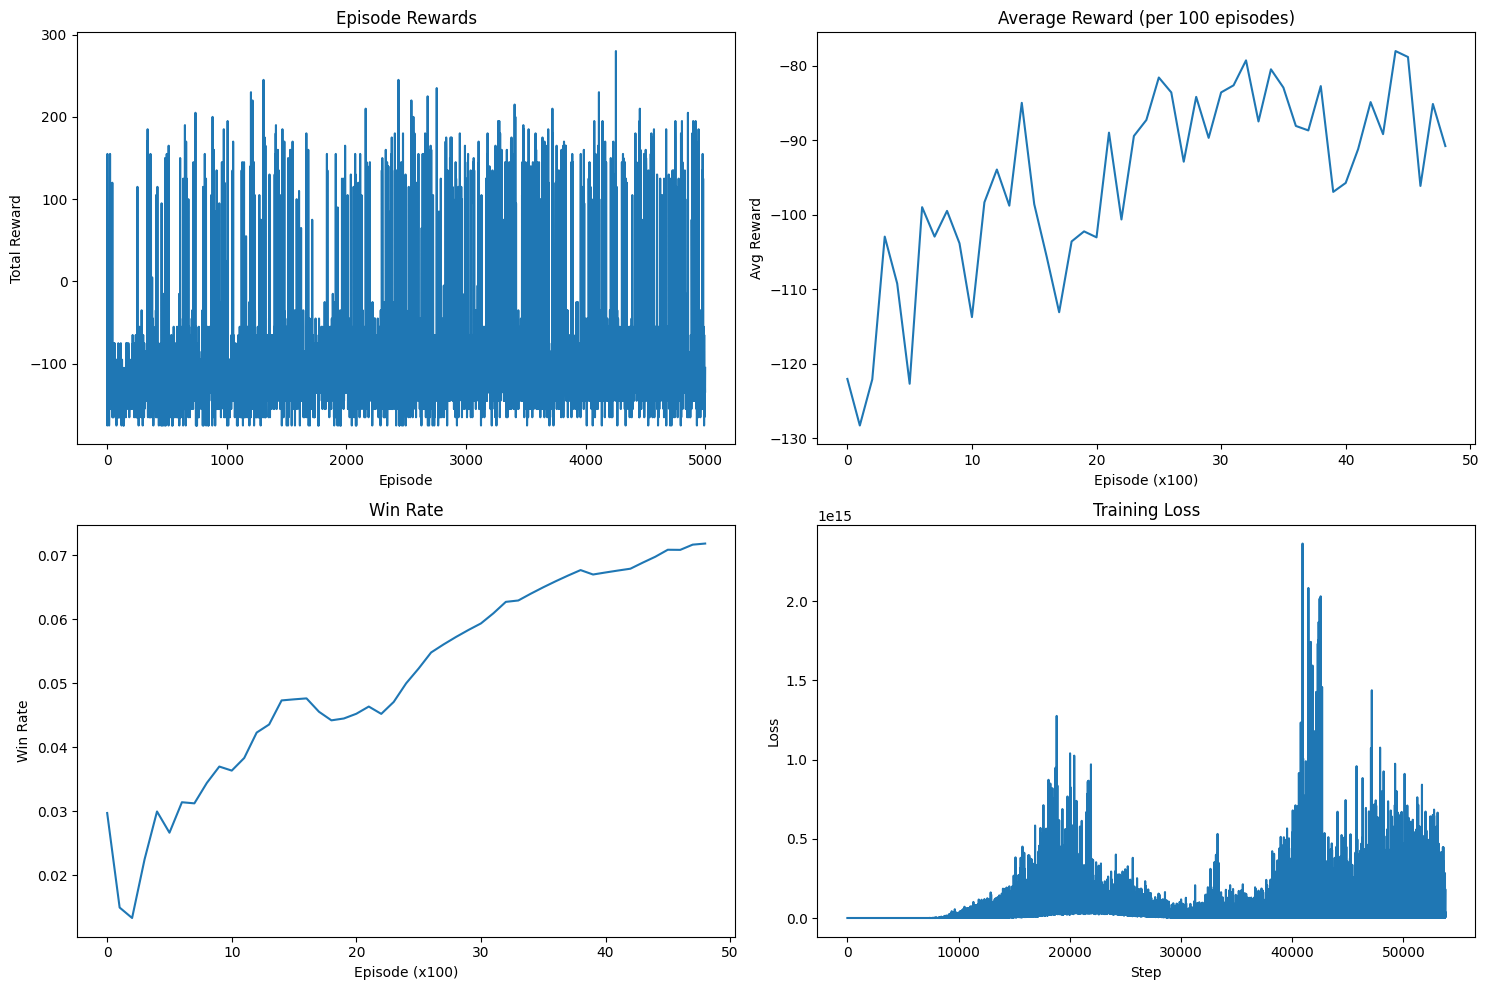


✅ Training Complete!
Final Win Rate: 7.18%
Model saved to dqn_agent.pth


In [4]:
"""
Hangman Solver - Part 2: Reinforcement Learning Agent
This notebook builds and trains a DQN agent that uses HMM probabilities
"""

import numpy as np
import pickle
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================================
# STEP 1: Load Trained HMMs
# ============================================================================

def load_models(filepath='hangman_models.pkl'):
    """Load trained HMMs and word list"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)

    with open('word_matcher.pkl', 'rb') as f:
        word_matcher = pickle.load(f)

    return data['hmms'], data['words'], word_matcher

# ============================================================================
# STEP 2: Hangman Environment
# ============================================================================

class HangmanEnv:
    """Hangman game environment for RL"""

    def __init__(self, words, hmms, word_matcher, max_wrong=6):
        self.words = words
        self.hmms = hmms
        self.word_matcher = word_matcher
        self.max_wrong = max_wrong
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

        self.reset()

    def reset(self, word=None):
        """Start a new game"""
        if word is None:
            self.target_word = random.choice(self.words).upper()
        else:
            self.target_word = word.upper()

        self.masked_word = '_' * len(self.target_word)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.game_over = False
        self.won = False

        return self.get_state()

    def get_state(self):
        """Get current state representation"""
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong - self.wrong_guesses,
            'game_over': self.game_over,
            'won': self.won
        }

    def step(self, letter):
        """
        Make a guess

        Returns:
            state, reward, done, info
        """
        letter = letter.upper()

        # Check for repeated guess
        if letter in self.guessed_letters:
            reward = -20  # Heavy penalty for repeated guess
            return self.get_state(), reward, self.game_over, {'repeated': True}

        self.guessed_letters.add(letter)

        # Check if letter is in word
        if letter in self.target_word:
            # Correct guess - update masked word
            new_masked = ''
            revealed_count = 0
            for i, char in enumerate(self.target_word):
                if char == letter:
                    new_masked += char
                    if self.masked_word[i] == '_':
                        revealed_count += 1
                else:
                    new_masked += self.masked_word[i]

            self.masked_word = new_masked

            # Reward based on number of positions revealed
            reward = 10 * revealed_count

            # Check if won
            if '_' not in self.masked_word:
                self.won = True
                self.game_over = True
                reward += 100  # Bonus for winning
        else:
            # Wrong guess
            self.wrong_guesses += 1
            reward = -15

            # Check if lost
            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                reward = -100  # Penalty for losing

        return self.get_state(), reward, self.game_over, {}

    def get_valid_actions(self):
        """Get list of valid letters to guess"""
        return [c for c in self.alphabet if c not in self.guessed_letters]

    def get_hmm_probs(self):
        """Get HMM probability distribution for current state"""
        word_length = len(self.masked_word)

        if word_length in self.hmms:
            hmm = self.hmms[word_length]
            return hmm.predict_letter_probs(self.masked_word, self.guessed_letters)
        else:
            # Fallback: uniform distribution
            valid = self.get_valid_actions()
            return {c: 1.0/len(valid) for c in valid}

    def get_word_filter_probs(self):
        """Get letter probabilities from matching words"""
        matching_words = self.word_matcher.get_matching_words(
            self.masked_word, self.guessed_letters
        )

        if not matching_words:
            # Fallback to HMM only
            return {}

        return self.word_matcher.get_letter_frequencies(
            matching_words, self.guessed_letters
        )

# ============================================================================
# STEP 3: Deep Q-Network
# ============================================================================

class DQN(nn.Module):
    """Deep Q-Network for action-value estimation"""

    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(state_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.network(x)

# ============================================================================
# STEP 4: State Encoding
# ============================================================================

class StateEncoder:
    """Encode game state into neural network input"""

    def __init__(self, max_word_length=20):
        self.max_word_length = max_word_length
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.letter_to_idx = {c: i for i, c in enumerate(self.alphabet)}

        # State vector size:
        # - masked word one-hot: max_length * 27 (26 letters + blank)
        # - guessed letters binary: 26
        # - lives left: 1
        # - HMM probs: 26
        # - word filter probs: 26
        self.state_size = (max_word_length * 27) + 26 + 1 + 26 + 26

    def encode(self, state, hmm_probs, filter_probs):
        """Encode state into vector"""

        vector = []

        # 1. Encode masked word (one-hot per position)
        masked = state['masked_word']
        for i in range(self.max_word_length):
            one_hot = [0] * 27
            if i < len(masked):
                char = masked[i]
                if char == '_':
                    one_hot[26] = 1  # Blank
                else:
                    one_hot[self.letter_to_idx[char]] = 1
            vector.extend(one_hot)

        # 2. Encode guessed letters (binary)
        guessed_vec = [0] * 26
        for letter in state['guessed_letters']:
            guessed_vec[self.letter_to_idx[letter]] = 1
        vector.extend(guessed_vec)

        # 3. Lives left (normalized)
        vector.append(state['lives_left'] / 6.0)

        # 4. HMM probabilities
        hmm_vec = [hmm_probs.get(c, 0) for c in self.alphabet]
        vector.extend(hmm_vec)

        # 5. Word filter probabilities
        filter_vec = [filter_probs.get(c, 0) for c in self.alphabet]
        vector.extend(filter_vec)

        return np.array(vector, dtype=np.float32)

# ============================================================================
# STEP 5: DQN Agent
# ============================================================================

class DQNAgent:
    """DQN Agent with experience replay and target network"""

    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

        # Hyperparameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate

        # Replay memory
        self.memory = deque(maxlen=10000)
        self.batch_size = 64

        # Networks
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_size, action_size).to(self.device)
        self.target_net = DQN(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state_vector, valid_actions, hmm_probs):
        """
        Choose action using epsilon-greedy policy
        Blend RL Q-values with HMM probabilities
        """

        # Exploration
        if np.random.rand() <= self.epsilon:
            # Weighted random choice based on HMM probs
            if hmm_probs and random.random() > 0.3:
                letters = list(hmm_probs.keys())
                probs = list(hmm_probs.values())
                if sum(probs) > 0:
                    probs = np.array(probs) / sum(probs)
                    return np.random.choice(letters, p=probs)
            return random.choice(valid_actions)

        # Exploitation: use Q-network
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_vector).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor).cpu().numpy()[0]

        # Blend with HMM probabilities
        action_scores = {}
        for letter in valid_actions:
            idx = self.alphabet.index(letter)
            q_val = q_values[idx]
            hmm_prob = hmm_probs.get(letter, 0)

            # Weighted combination
            action_scores[letter] = 0.7 * q_val + 0.3 * hmm_prob * 10

        # Choose best action
        best_letter = max(action_scores, key=action_scores.get)
        return best_letter

    def replay(self):
        """Train on batch from replay memory"""

        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        states = torch.FloatTensor([t[0] for t in batch]).to(self.device)
        actions = torch.LongTensor([self.alphabet.index(t[1]) for t in batch]).to(self.device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(self.device)
        next_states = torch.FloatTensor([t[3] for t in batch]).to(self.device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(self.device)

        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Next Q values from target network
        next_q = self.target_net(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss and update
        loss = self.criterion(current_q, target_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Copy weights from policy network to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ============================================================================
# STEP 6: Training Loop
# ============================================================================

def train_agent(env, agent, encoder, episodes=5000, update_target_every=10):
    """Train the DQN agent"""

    scores = []
    avg_scores = []
    losses = []
    win_rates = []

    wins = 0

    for episode in tqdm(range(episodes), desc="Training"):
        state = env.reset()
        state_vector = encoder.encode(
            state,
            env.get_hmm_probs(),
            env.get_word_filter_probs()
        )

        total_reward = 0
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            hmm_probs = env.get_hmm_probs()
            action = agent.act(state_vector, valid_actions, hmm_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_vector = encoder.encode(
                next_state,
                env.get_hmm_probs(),
                env.get_word_filter_probs()
            )

            agent.remember(state_vector, action, reward, next_state_vector, done)

            loss = agent.replay()
            if loss:
                losses.append(loss)

            state = next_state
            state_vector = next_state_vector
            total_reward += reward

        if env.won:
            wins += 1

        scores.append(total_reward)

        # Update target network
        if episode % update_target_every == 0:
            agent.update_target_network()

        # Decay epsilon
        agent.decay_epsilon()

        # Track metrics
        if episode % 100 == 0 and episode > 0:
            avg_score = np.mean(scores[-100:])
            win_rate = wins / (episode + 1)
            avg_scores.append(avg_score)
            win_rates.append(win_rate)

            print(f"\nEpisode {episode}/{episodes}")
            print(f"  Avg Score: {avg_score:.2f}")
            print(f"  Win Rate: {win_rate:.2%}")
            print(f"  Epsilon: {agent.epsilon:.3f}")
            print(f"  Recent Wins: {sum(1 for i in range(max(0, episode-99), episode+1) if scores[i] > 0)}/100")

    return agent, scores, avg_scores, win_rates, losses

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("=" * 60)
    print("HANGMAN RL TRAINING")
    print("=" * 60)

    # Load models
    print("\nLoading HMMs...")
    hmms, words, word_matcher = load_models()

    # Create environment
    print("Creating environment...")
    env = HangmanEnv(words, hmms, word_matcher)

    # Create encoder and agent
    encoder = StateEncoder()
    agent = DQNAgent(encoder.state_size, 26)

    print(f"\nState size: {encoder.state_size}")
    print(f"Action size: 26")
    print(f"Device: {agent.device}")

    # Train
    print("\nStarting training...")
    agent, scores, avg_scores, win_rates, losses = train_agent(
        env, agent, encoder, episodes=5000
    )

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Scores
    axes[0, 0].plot(scores)
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')

    # Average scores
    axes[0, 1].plot(avg_scores)
    axes[0, 1].set_title('Average Reward (per 100 episodes)')
    axes[0, 1].set_xlabel('Episode (x100)')
    axes[0, 1].set_ylabel('Avg Reward')

    # Win rate
    axes[1, 0].plot(win_rates)
    axes[1, 0].set_title('Win Rate')
    axes[1, 0].set_xlabel('Episode (x100)')
    axes[1, 0].set_ylabel('Win Rate')

    # Loss
    if losses:
        axes[1, 1].plot(losses)
        axes[1, 1].set_title('Training Loss')
        axes[1, 1].set_xlabel('Step')
        axes[1, 1].set_ylabel('Loss')

    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()

    # Save trained agent
    torch.save({
        'policy_net': agent.policy_net.state_dict(),
        'target_net': agent.target_net.state_dict(),
        'optimizer': agent.optimizer.state_dict(),
        'epsilon': agent.epsilon
    }, 'dqn_agent.pth')

    print("\n✅ Training Complete!")
    print(f"Final Win Rate: {win_rates[-1]:.2%}")
    print(f"Model saved to dqn_agent.pth")

HANGMAN EVALUATION

Loading models...
Loading test words...
Test file not found. Will create test set from corpus.
Created test set of 2000 words from corpus

Evaluating hybrid agent...


Evaluating Hybrid Agent:   0%|          | 0/2000 [00:00<?, ?it/s]


Word: HUMANITARIANIZE
  Won: True
  Wrong: 1
  Repeated: 0
  Guesses: O H A I N M U T R Z E

Word: PORTULAN
  Won: True
  Wrong: 3
  Repeated: 0
  Guesses: O H I E R L U P T A N


Evaluating Hybrid Agent:   0%|          | 3/2000 [00:00<01:38, 20.26it/s]


Word: CAMATA
  Won: False
  Wrong: 6
  Repeated: 0
  Guesses: O H I E R N

Word: INTROMITTER
  Won: True
  Wrong: 1
  Repeated: 0
  Guesses: O H I T R N M E


Evaluating Hybrid Agent:   0%|          | 6/2000 [00:00<01:57, 16.99it/s]


Word: SEGMENTED
  Won: True
  Wrong: 4
  Repeated: 0
  Guesses: O H I E R S G M N T D

Word: DISCORDANCY
  Won: True
  Wrong: 1
  Repeated: 0
  Guesses: O H I R D C S A N Y

Word: WEAPONLESS
  Won: True
  Wrong: 3
  Repeated: 0
  Guesses: O H I E S R W A P N L


Evaluating Hybrid Agent:   0%|          | 8/2000 [00:00<02:06, 15.75it/s]


Word: UNRELISHED
  Won: True
  Wrong: 2
  Repeated: 0
  Guesses: O H I S A E U N R L D


Evaluating Hybrid Agent:   0%|          | 10/2000 [00:00<01:57, 16.92it/s]


Word: GINGLYMOSTOMA
  Won: True
  Wrong: 0
  Repeated: 0
  Guesses: O S M G I N L Y T A

Word: INGESTIVE
  Won: True
  Wrong: 2
  Repeated: 0
  Guesses: O H I N E V S T G


Evaluating Hybrid Agent: 100%|██████████| 2000/2000 [01:48<00:00, 18.43it/s]



EVALUATION RESULTS

Total Games: 2000
Total Wins: 1888
Success Rate: 94.40%

Total Wrong Guesses: 4258
Avg Wrong Guesses: 2.129

Total Repeated Guesses: 0
Avg Repeated Guesses: 0.000

FINAL SCORE: -19402.00

Sample Failed Words (showing first 10):
  CAMATA: 6 wrong, guesses: O H I E R N
  PUR: 6 wrong, guesses: O H I E R A F
  FACT: 6 wrong, guesses: O H E I R N
  STAVER: 6 wrong, guesses: O H I E R N A L S V P
  CADLOCK: 6 wrong, guesses: O I E H R N T
  LOPPY: 6 wrong, guesses: O H I E N R A
  BRAD: 6 wrong, guesses: O I H E R N A G
  SAMEL: 6 wrong, guesses: O H I E R N A D
  CABBLE: 6 wrong, guesses: O H I E R N A L B J
  NETE: 6 wrong, guesses: O H I E L C S


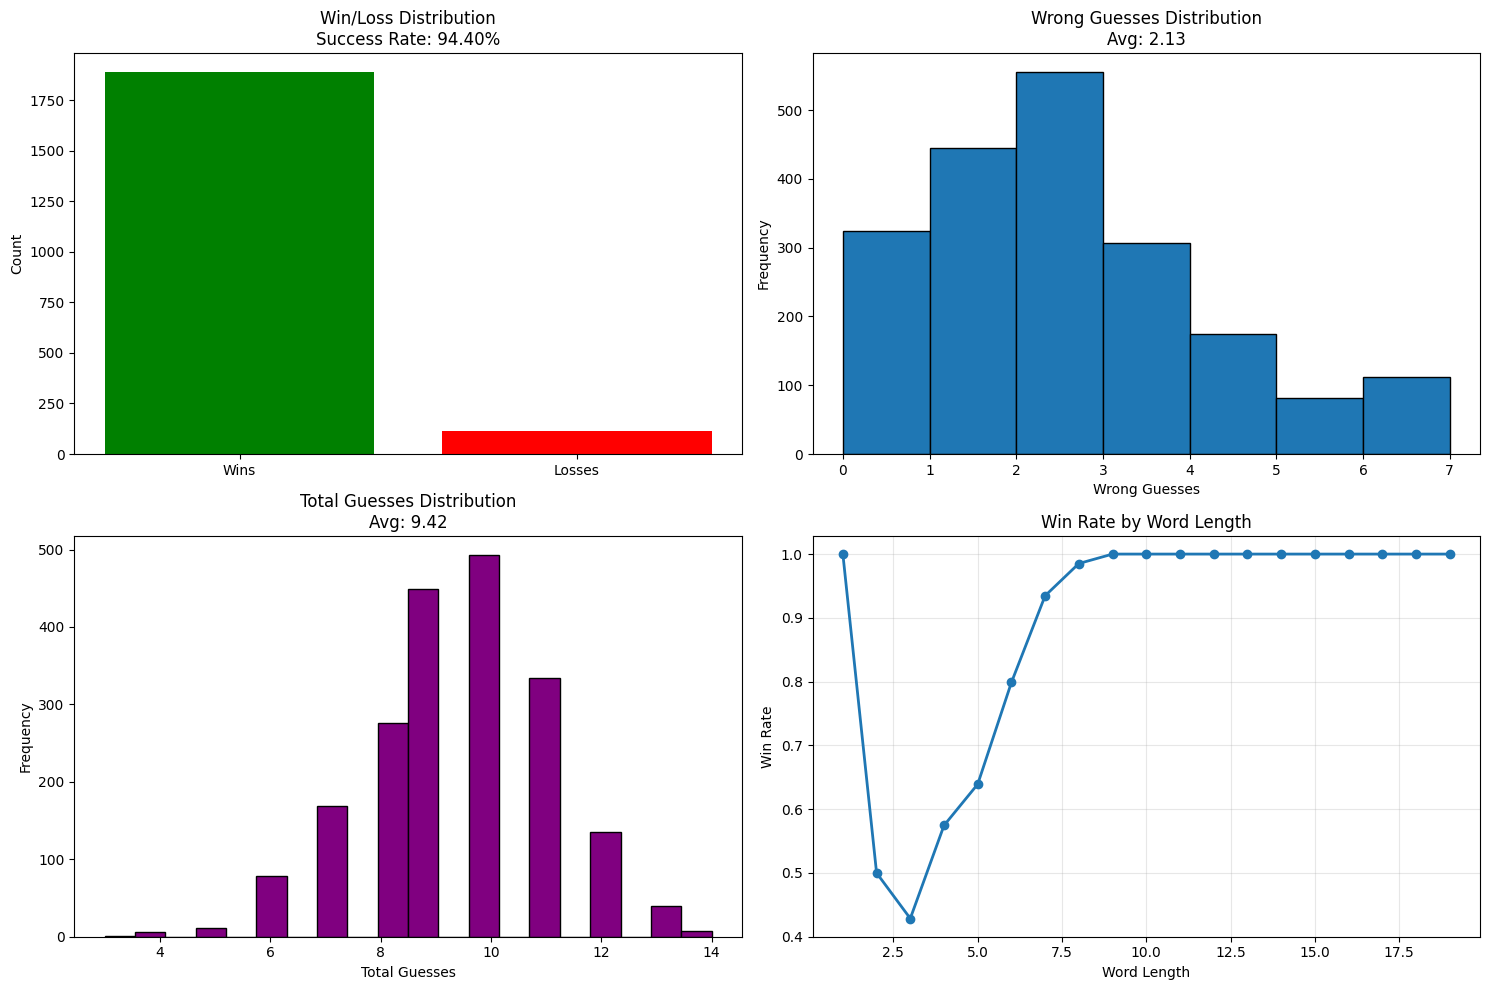


✅ Evaluation Complete!
Results saved to evaluation_results.pkl


In [5]:
"""
Hangman Solver - Part 3: Evaluation on Test Set
This notebook evaluates the trained agent on 2000 test games
"""

import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Import classes from training notebooks (copy them here or import)
# For Colab, you would run the previous notebooks first, then this one

# ============================================================================
# STEP 1: Load Everything
# ============================================================================

def load_test_words(filepath='test_words.txt'):
    """Load test set words"""
    try:
        with open(filepath, 'r') as f:
            words = [line.strip().upper() for line in f if line.strip()]
        return words
    except FileNotFoundError:
        print("Test file not found. Will create test set from corpus.")
        return None

def create_test_set_from_corpus(all_words, num_test=2000, seed=42):
    """Create a test set by sampling from corpus"""
    import random
    random.seed(seed)

    # Sample 2000 random words
    test_words = random.sample(all_words, min(num_test, len(all_words)))

    print(f"Created test set of {len(test_words)} words from corpus")
    return test_words

def load_trained_agent(encoder, checkpoint_path='dqn_agent.pth'):
    """Load trained DQN agent"""
    agent = DQNAgent(encoder.state_size, 26)

    checkpoint = torch.load(checkpoint_path)
    agent.policy_net.load_state_dict(checkpoint['policy_net'])
    agent.target_net.load_state_dict(checkpoint['target_net'])
    agent.epsilon = 0.0  # No exploration during evaluation

    return agent

# ============================================================================
# STEP 2: Evaluation Function
# ============================================================================

def evaluate_agent(env, agent, encoder, test_words, verbose=False):
    """
    Evaluate agent on test words

    Returns detailed statistics
    """

    results = []
    total_wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0

    for i, word in enumerate(tqdm(test_words, desc="Evaluating")):
        state = env.reset(word)
        state_vector = encoder.encode(
            state,
            env.get_hmm_probs(),
            env.get_word_filter_probs()
        )

        done = False
        wrong_guesses = 0
        repeated_guesses = 0
        guesses_made = []

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            # Get action from agent (no exploration)
            hmm_probs = env.get_hmm_probs()
            filter_probs = env.get_word_filter_probs()

            # Use greedy policy with HMM+filter guidance
            action = agent.act(state_vector, valid_actions, hmm_probs)
            guesses_made.append(action)

            next_state, reward, done, info = env.step(action)

            if info.get('repeated', False):
                repeated_guesses += 1
            elif reward < 0:
                wrong_guesses += 1

            next_state_vector = encoder.encode(
                next_state,
                env.get_hmm_probs(),
                env.get_word_filter_probs()
            )

            state = next_state
            state_vector = next_state_vector

        won = env.won

        if won:
            total_wins += 1

        total_wrong_guesses += wrong_guesses
        total_repeated_guesses += repeated_guesses

        result = {
            'word': word,
            'won': won,
            'wrong_guesses': wrong_guesses,
            'repeated_guesses': repeated_guesses,
            'total_guesses': len(guesses_made),
            'guesses': guesses_made
        }
        results.append(result)

        if verbose and i < 10:
            print(f"\nWord: {word}")
            print(f"  Won: {won}")
            print(f"  Wrong: {wrong_guesses}")
            print(f"  Repeated: {repeated_guesses}")
            print(f"  Guesses: {' '.join(guesses_made)}")

    # Calculate metrics
    num_games = len(test_words)
    success_rate = total_wins / num_games
    avg_wrong = total_wrong_guesses / num_games
    avg_repeated = total_repeated_guesses / num_games

    # Calculate final score
    final_score = (success_rate * num_games) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

    stats = {
        'num_games': num_games,
        'total_wins': total_wins,
        'success_rate': success_rate,
        'total_wrong_guesses': total_wrong_guesses,
        'total_repeated_guesses': total_repeated_guesses,
        'avg_wrong_guesses': avg_wrong,
        'avg_repeated_guesses': avg_repeated,
        'final_score': final_score,
        'results': results
    }

    return stats

# ============================================================================
# STEP 3: Enhanced Evaluation with Smart Strategy
# ============================================================================

class HybridAgent:
    """
    Hybrid agent that combines:
    1. Word filtering (most important)
    2. HMM probabilities
    3. RL Q-values
    """

    def __init__(self, dqn_agent, encoder):
        self.dqn_agent = dqn_agent
        self.encoder = encoder
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    def choose_action(self, env, state):
        """Choose best action using hybrid strategy"""

        valid_actions = env.get_valid_actions()
        if not valid_actions:
            return None

        # Get matching words
        matching_words = env.word_matcher.get_matching_words(
            state['masked_word'], state['guessed_letters']
        )

        # Strategy 1: If we have few matching words, use their letter frequencies
        if len(matching_words) <= 20 and matching_words:
            filter_probs = env.word_matcher.get_letter_frequencies(
                matching_words, state['guessed_letters']
            )

            if filter_probs:
                # Use word filter probs directly (most accurate)
                best_letter = max(filter_probs.items(), key=lambda x: x[1])[0]
                return best_letter

        # Strategy 2: Blend HMM + word filter + DQN
        hmm_probs = env.get_hmm_probs()
        filter_probs = env.get_word_filter_probs()

        # Get DQN Q-values
        state_vector = self.encoder.encode(state, hmm_probs, filter_probs)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_vector).unsqueeze(0).to(self.dqn_agent.device)
            q_values = self.dqn_agent.policy_net(state_tensor).cpu().numpy()[0]

        # Combine all sources
        action_scores = {}
        for letter in valid_actions:
            idx = self.alphabet.index(letter)

            q_val = q_values[idx]
            hmm_prob = hmm_probs.get(letter, 0)
            filter_prob = filter_probs.get(letter, 0)

            # Weighted combination (prioritize word filtering)
            score = 0.2 * q_val + 0.3 * hmm_prob * 10 + 0.5 * filter_prob * 10
            action_scores[letter] = score

        best_letter = max(action_scores, key=action_scores.get)
        return best_letter

def evaluate_hybrid_agent(env, hybrid_agent, test_words, verbose=False):
    """Evaluate hybrid agent"""

    results = []
    total_wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0

    for i, word in enumerate(tqdm(test_words, desc="Evaluating Hybrid Agent")):
        state = env.reset(word)

        done = False
        wrong_guesses = 0
        repeated_guesses = 0
        guesses_made = []

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = hybrid_agent.choose_action(env, state)
            if action is None:
                break

            guesses_made.append(action)

            next_state, reward, done, info = env.step(action)

            if info.get('repeated', False):
                repeated_guesses += 1
            elif reward < 0:
                wrong_guesses += 1

            state = next_state

        won = env.won

        if won:
            total_wins += 1

        total_wrong_guesses += wrong_guesses
        total_repeated_guesses += repeated_guesses

        result = {
            'word': word,
            'won': won,
            'wrong_guesses': wrong_guesses,
            'repeated_guesses': repeated_guesses,
            'total_guesses': len(guesses_made),
            'guesses': guesses_made
        }
        results.append(result)

        if verbose and i < 10:
            print(f"\nWord: {word}")
            print(f"  Won: {won}")
            print(f"  Wrong: {wrong_guesses}")
            print(f"  Repeated: {repeated_guesses}")
            print(f"  Guesses: {' '.join(guesses_made)}")

    # Calculate metrics
    num_games = len(test_words)
    success_rate = total_wins / num_games
    avg_wrong = total_wrong_guesses / num_games
    avg_repeated = total_repeated_guesses / num_games

    final_score = (success_rate * num_games) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

    stats = {
        'num_games': num_games,
        'total_wins': total_wins,
        'success_rate': success_rate,
        'total_wrong_guesses': total_wrong_guesses,
        'total_repeated_guesses': total_repeated_guesses,
        'avg_wrong_guesses': avg_wrong,
        'avg_repeated_guesses': avg_repeated,
        'final_score': final_score,
        'results': results
    }

    return stats

# ============================================================================
# STEP 4: Visualization
# ============================================================================

def plot_evaluation_results(stats):
    """Plot evaluation results"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Win/Loss distribution
    wins = stats['total_wins']
    losses = stats['num_games'] - wins
    axes[0, 0].bar(['Wins', 'Losses'], [wins, losses], color=['green', 'red'])
    axes[0, 0].set_title(f"Win/Loss Distribution\nSuccess Rate: {stats['success_rate']:.2%}")
    axes[0, 0].set_ylabel('Count')

    # Wrong guesses distribution
    wrong_guesses = [r['wrong_guesses'] for r in stats['results']]
    axes[0, 1].hist(wrong_guesses, bins=range(0, 8), edgecolor='black')
    axes[0, 1].set_title(f"Wrong Guesses Distribution\nAvg: {stats['avg_wrong_guesses']:.2f}")
    axes[0, 1].set_xlabel('Wrong Guesses')
    axes[0, 1].set_ylabel('Frequency')

    # Total guesses distribution
    total_guesses = [r['total_guesses'] for r in stats['results']]
    axes[1, 0].hist(total_guesses, bins=20, edgecolor='black', color='purple')
    axes[1, 0].set_title(f"Total Guesses Distribution\nAvg: {np.mean(total_guesses):.2f}")
    axes[1, 0].set_xlabel('Total Guesses')
    axes[1, 0].set_ylabel('Frequency')

    # Performance by word length
    length_stats = {}
    for r in stats['results']:
        length = len(r['word'])
        if length not in length_stats:
            length_stats[length] = {'wins': 0, 'total': 0}
        length_stats[length]['total'] += 1
        if r['won']:
            length_stats[length]['wins'] += 1

    lengths = sorted(length_stats.keys())
    win_rates = [length_stats[l]['wins'] / length_stats[l]['total'] for l in lengths]

    axes[1, 1].plot(lengths, win_rates, marker='o', linewidth=2)
    axes[1, 1].set_title('Win Rate by Word Length')
    axes[1, 1].set_xlabel('Word Length')
    axes[1, 1].set_ylabel('Win Rate')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('evaluation_results.png')
    plt.show()

def print_summary(stats):
    """Print summary statistics"""

    print("\n" + "=" * 60)
    print("EVALUATION RESULTS")
    print("=" * 60)
    print(f"\nTotal Games: {stats['num_games']}")
    print(f"Total Wins: {stats['total_wins']}")
    print(f"Success Rate: {stats['success_rate']:.2%}")
    print(f"\nTotal Wrong Guesses: {stats['total_wrong_guesses']}")
    print(f"Avg Wrong Guesses: {stats['avg_wrong_guesses']:.3f}")
    print(f"\nTotal Repeated Guesses: {stats['total_repeated_guesses']}")
    print(f"Avg Repeated Guesses: {stats['avg_repeated_guesses']:.3f}")
    print(f"\n{'='*60}")
    print(f"FINAL SCORE: {stats['final_score']:.2f}")
    print("=" * 60)

    # Show some failed words
    failed = [r for r in stats['results'] if not r['won']]
    if failed:
        print(f"\nSample Failed Words (showing first 10):")
        for r in failed[:10]:
            print(f"  {r['word']}: {r['wrong_guesses']} wrong, guesses: {' '.join(r['guesses'])}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("=" * 60)
    print("HANGMAN EVALUATION")
    print("=" * 60)

    # Load everything
    print("\nLoading models...")
    hmms, words, word_matcher = load_models()

    print("Loading test words...")
    test_words = load_test_words('test_words.txt')

    # If no test file, create from corpus
    if test_words is None:
        test_words = create_test_set_from_corpus(words, num_test=2000)
    else:
        print(f"Loaded {len(test_words)} test words from file")

    if test_words is None or len(test_words) == 0:
        print("ERROR: No test words available!")
        exit()

    # Create environment
    env = HangmanEnv(words, hmms, word_matcher)

    # Load trained agent
    encoder = StateEncoder()
    agent = load_trained_agent(encoder)

    # Create hybrid agent
    hybrid_agent = HybridAgent(agent, encoder)

    # Evaluate
    print("\nEvaluating hybrid agent...")
    stats = evaluate_hybrid_agent(env, hybrid_agent, test_words, verbose=True)

    # Print results
    print_summary(stats)

    # Plot results
    plot_evaluation_results(stats)

    # Save results
    with open('evaluation_results.pkl', 'wb') as f:
        pickle.dump(stats, f)

    print("\n✅ Evaluation Complete!")
    print("Results saved to evaluation_results.pkl")